<a href="https://colab.research.google.com/github/haturusinghe/cnn-gender-inceptionV3/blob/master/age_class_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


# Extracting Data

!tar -czvf "/content/drive/MyDrive/new_datasets/part1.tar.gz" "/content/drive/MyDrive/UTKFace_w"   

In [ ]:
!tar -xzvf "/content/drive/MyDrive/new_datasets/part1.tar.gz" -C "/content/drive/MyDrive/UTKFace_w"  

In [ ]:
!pwd

/content


# Initial Imports

In [ ]:
#Initial Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime

# To download checkpoints, Keras models, TFLite models
from google.colab import files

In [ ]:
dataset_folder_name = '/content/drive/MyDrive/cnn-test-1/datasets/faces/UTKFace/'
file_pattern = dataset_folder_name+"*.jpg"
print(file_pattern)

/content/drive/MyDrive/cnn-test-1/datasets/faces/UTKFace/*.jpg


# Make Dataset

In [ ]:
# Fraction of the dataset to be used for testing.
TRAIN_TEST_SPLIT = 0.3

# Image size for our model.
MODEL_INPUT_IMAGE_SIZE = [ 200 , 200 ]

# Number of samples to take from dataset
N = 20000

# Trick to one-hot encode the label.
#y1 = tf.constant( [ 1. , 0. ] , dtype='float32' ) 
#y2 = tf.constant( [ 0. , 1. ] , dtype='float32' ) #Use CCE if using one-hot

In [ ]:
list_ds = tf.data.Dataset.list_files(file_pattern, shuffle=True ) #List of files of all training images

In [ ]:
for line in list_ds.take(5):
  print(line.numpy())
  #parts_x = tf.strings.split( line , '/' )
  #parts_xx = tf.strings.split( parts_x[ 8 ] , '_' )
  #print(parts_xx)

b'/content/drive/MyDrive/cnn-test-1/datasets/faces/UTKFace/1_1_2_20161219195923075.jpg.chip.jpg'
b'/content/drive/MyDrive/cnn-test-1/datasets/faces/UTKFace/26_1_4_20170117152921443.jpg.chip.jpg'
b'/content/drive/MyDrive/cnn-test-1/datasets/faces/UTKFace/19_1_0_20170103175624137.jpg.chip.jpg'
b'/content/drive/MyDrive/cnn-test-1/datasets/faces/UTKFace/4_0_3_20161220223111195.jpg.chip.jpg'
b'/content/drive/MyDrive/cnn-test-1/datasets/faces/UTKFace/1_0_3_20161219225616560.jpg.chip.jpg'


## Extract Data From image

In [ ]:
# This method will be mapped for each filename in `list_ds`. 
def parse_image( filename ):

    # Read the image from the filename and resize it.
    image_raw = tf.io.read_file( filename )
    image = tf.image.decode_jpeg( image_raw , channels=3 ) 
    image = tf.image.resize( image , MODEL_INPUT_IMAGE_SIZE ) / 255

    # Split the filename to get the age and the gender. Convert the age ( str ) and the gender ( str ) to dtype float32.
    parts_pre = tf.strings.split( filename , '/' )
    parts = tf.strings.split( parts_pre[ 8 ] , '_' ) # 6 for sample set , 8 for dataset

    # Normalize
    age = tf.strings.to_number( parts[ 0 ] )
    lower = ( age - 5 ) / 116
    upper = ( age + 5 ) / 116

    return image , [ lower , upper ]

In [ ]:
dataset = list_ds.map( parse_image , num_parallel_calls=tf.data.AUTOTUNE )
dataset = dataset.take( N )

## Separate Test and Train sets

In [ ]:
# Create train and test splits of the dataset.
num_examples_in_test_ds = int( dataset.cardinality().numpy() * TRAIN_TEST_SPLIT )

test_ds = dataset.take( num_examples_in_test_ds )
train_ds = dataset.skip( num_examples_in_test_ds )

print( 'Num examples in train ds {}'.format( train_ds.cardinality() ) )
print( 'Num examples in test ds {}'.format( test_ds.cardinality() ) )

Num examples in train ds 14000
Num examples in test ds 6000


In [ ]:
for x , y in dataset.batch( 5 ).take( 2 ):
    print( y )

tf.Tensor(
[[0.06896552 0.15517241]
 [0.95689654 1.0431035 ]
 [0.2672414  0.35344827]
 [0.38793105 0.47413793]
 [0.47413793 0.5603448 ]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[0.22413793 0.31034482]
 [0.12068965 0.20689656]
 [0.22413793 0.31034482]
 [0.3448276  0.43103448]
 [0.41379312 0.5       ]], shape=(5, 2), dtype=float32)


#Define Model

In [ ]:
# Negative slope coefficient for LeakyReLU.
leaky_relu_alpha = 0.2

# A lite model uses Separable Convolutions
lite_model = True

# Define the conv block.
def conv( x , num_filters , kernel_size=( 3 , 3 ) , strides=1 ):
    if lite_model:
        x = tf.keras.layers.SeparableConv2D( num_filters ,
                                            kernel_size=kernel_size ,
                                            strides=strides, 
                                            use_bias=False ,
                                            kernel_initializer=tf.keras.initializers.HeNormal() ,
                                            kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                             )( x )
    else:
        x = tf.keras.layers.Conv2D( num_filters ,
                                   kernel_size=kernel_size ,
                                   strides=strides ,
                                   use_bias=False ,
                                   kernel_initializer=tf.keras.initializers.HeNormal() ,
                                   kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                    )( x )

    x = tf.keras.layers.BatchNormalization()( x )
    x = tf.keras.layers.LeakyReLU( leaky_relu_alpha )( x )
    return x

In [ ]:
# Dense layers
def dense( x , filters , dropout_rate ):
    x = tf.keras.layers.Dense( filters , kernel_regularizer=tf.keras.regularizers.L2( 0.1 ) , bias_regularizer=tf.keras.regularizers.L2( 0.1 ) )( x )
    x = tf.keras.layers.LeakyReLU( alpha=leaky_relu_alpha )( x )
    x = tf.keras.layers.Dropout( dropout_rate )( x )
    return x


In [ ]:
# No. of convolution layers to be added.
num_blocks = 6
# Num filters for each conv layer.
num_filters = [ 16 , 32 , 64 , 128 , 256 , 256 ]
# Kernel sizes for each conv layer.
kernel_sizes = [ 3 , 3 , 3 , 3 , 3 , 3 ]

# Init a Input Layer.
inputs = tf.keras.layers.Input( shape=MODEL_INPUT_IMAGE_SIZE + [ 3 ] , name='input_image' )

In [ ]:
# Custom preprocessing layer to modify image brightness randomly.
class RandomBrightness( tf.keras.layers.Layer ):

    def __init__( self , max_delta ):
        super( RandomBrightness , self ).__init__()
        self.__max_delta = max_delta

    def call( self , inputs ):
        return tf.image.random_brightness( inputs , self.__max_delta )

    def get_config( self ):
        return { "max_delta" : self.__max_delta }

In [ ]:
preprocessing_module = [
    tf.keras.layers.experimental.preprocessing.RandomFlip( mode='vertical' ) , 
    #RandomBrightness( max_delta=0.2 ) , 
    tf.keras.layers.experimental.preprocessing.RandomRotation( factor=0.1 )
]

In [ ]:
x = inputs
# Add Preprocessing layers after Input Layer
#for layer in preprocessing_module:
#    x = layer( x )

# Add conv blocks sequentially
for i in range( num_blocks ):
    x = conv( x , num_filters=num_filters[ i ] , kernel_size=kernel_sizes[ i ] )
    x = tf.keras.layers.MaxPooling2D()( x )

# Flatten the output of the last Conv layer.
x = tf.keras.layers.Flatten()( x )
conv_output = x 

# Add Dense layers ( Dense -> LeakyReLU -> Dropout )
x1 = dense( conv_output , 256 , 0.6 )
x1 = dense( x1 , 64 , 0.4 )
x1 = dense( x1 , 32 , 0.2 )
outputs_lower = tf.keras.layers.Dense( 1 , activation='relu' , name='output_lower_bound' )( x1 )

x2 = dense( conv_output , 256 , 0.6 )
x2 = dense( x2 , 64 , 0.4 )
x2 = dense( x2 , 32 , 0.2 )
outputs_upper = tf.keras.layers.Dense( 1 , activation='relu' , name='output_upper_bound' )( x2 )

# Build the Model
model_age = tf.keras.models.Model( inputs , [ outputs_lower , outputs_upper ] )

In [ ]:
model_age.summary()

In [ ]:
tf.keras.utils.plot_model( model_age , to_file='architecture.png',show_shapes=True )

In [ ]:
#Run this cell to visualize the training of the model in TensorBoard ( in this notebook itself ).
# %load_ext tensorboard
# %tensorboard --logdir tb_logs/

# Compiling Model

In [ ]:
!pwd

/content


In [ ]:
#dir_loc = '/content/drive/MyDrive/cnn-test-1'
#print(os.path.join(dir_loc, "tb_logs" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )) 

/content/drive/MyDrive/cnn-test-1/tb_logs/20210817-094243


In [ ]:
# Initial learning rate
learning_rate = 0.001

num_epochs = 50 
batch_size = 128

# Batch and repeat `train_ds` and `test_ds`.
train_ds = train_ds.batch( batch_size )
test_ds = test_ds.batch( batch_size )

In [ ]:
#save_dir = 'train-1/cp.ckpt'
save_dir = '/content/drive/MyDrive/cnn-test-1/ckpt/'
save_dir = save_dir + '{epoch:02d}--{val_loss:.2f}.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( save_dir,verbose=1,save_best_only=False , monitor='val_loss' , mode='min' , ) #Checkpoint after every epoch

dir_loc = '/content/drive/MyDrive/cnn-test-1'
logdir = os.path.join(dir_loc, "tb_logs_age" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S") ) #tensorboard logs save location
tensorboard_callback = tf.keras.callbacks.TensorBoard( logdir )


# Init LR Scheduler
def scheduler( epochs , learning_rate ):
    if epochs < num_epochs * 0.25:
        return learning_rate
    elif epochs < num_epochs * 0.5:
        return 0.0005
    elif epochs < num_epochs * 0.75:
        return 0.0001
    else:
        return 0.000095

lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler( scheduler )

# Init Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping( monitor='val_loss' , patience=10 )

# Compile the model
model_age.compile( 
    loss=tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam( learning_rate ) , 
    metrics=[ 'mae' ]
)

# Train Model

In [ ]:
model_age.fit( 
    train_ds, 
    epochs=num_epochs,  
    validation_data=test_ds,
    verbose = 1, 
    callbacks=[ checkpoint_callback , tensorboard_callback , lr_schedule_callback , early_stopping_callback ]
)

Epoch 1/50
110/110 [==============================] - 2469s 16s/step - loss: 28.5368 - output_lower_bound_loss: 0.2387 - output_upper_bound_loss: 0.1998 - output_lower_bound_mae: 0.2387 - output_upper_bound_mae: 0.1998 - val_loss: 5.0309 - val_output_lower_bound_loss: 0.1660 - val_output_upper_bound_loss: 0.1401 - val_output_lower_bound_mae: 0.1660 - val_output_upper_bound_mae: 0.1401

Epoch 00001: val_loss improved from inf to 5.03094, saving model to /content/drive/MyDrive/cnn-test-1/ckpt/01--5.03.h5
Epoch 2/50
110/110 [==============================] - 456s 3s/step - loss: 2.0160 - output_lower_bound_loss: 0.1081 - output_upper_bound_loss: 0.1068 - output_lower_bound_mae: 0.1081 - output_upper_bound_mae: 0.1068 - val_loss: 0.7974 - val_output_lower_bound_loss: 0.1378 - val_output_upper_bound_loss: 0.1365 - val_output_lower_bound_mae: 0.1378 - val_output_upper_bound_mae: 0.1365

Epoch 00002: val_loss improved from 5.03094 to 0.79737, saving model to /content/drive/MyDrive/cnn-test-1/

# Tensorboard

In [ ]:
!load_ext tensorboard
!tensorboard --logdir=logdir

In [ ]:
https://learn.zoom.us/j/65164545401?pwd=Z2JudXFTZHZBSUJwSU8vM2lGNmo3UT09

#Evaluate Model

In [ ]:
load_dir = '/content/drive/MyDrive/cnn-test-1/ckpt/46--0.13.h5'

In [ ]:
model_age_loaded = tf.keras.models.load_model( load_dir )

In [ ]:
model_age_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 198, 198, 16) 75          input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 198, 198, 16) 64          separable_conv2d[0][0]           
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 198, 198, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
p = model_age_loaded.evaluate( test_ds )
print( p )

47/47 [==============================] - 674s 14s/step - loss: 0.1338 - output_lower_bound_loss: 0.0553 - output_upper_bound_loss: 0.0556 - output_lower_bound_mae: 0.0553 - output_upper_bound_mae: 0.0556
[0.13382259011268616, 0.0552913062274456, 0.05563798174262047, 0.0552913062274456, 0.05563798174262047]


#Visualize

In [ ]:

fig = plt.figure( figsize=( 10 , 15 ) )
rows = 5
columns = 2

i = 1
for image , label in test_ds.unbatch().take( 10 ):
    image = image.numpy()
    fig.add_subplot( rows , columns , i )
    plt.imshow( image )
    label_ = model_age_loaded.predict( np.expand_dims( image , 0 ) ) * 116
    label_ = label_
    #print( label_ )
    plt.axis( 'off' )
    plt.title( 'Predicted age : {}, actual age : {}'.format( label_ , ( label.numpy() * 116 ).astype( np.int8 ) ) )
    i += 1

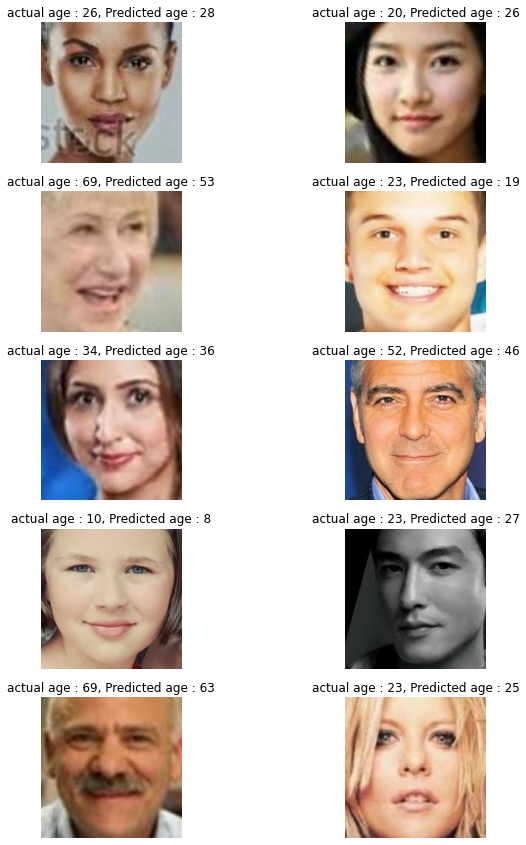

In [ ]:
fig = plt.figure( figsize=( 10 , 15 ) )
rows = 5
columns = 2
i = 1
for image , label in test_ds.unbatch().take( 10 ):
  pred = model_age_loaded.predict(np.expand_dims( image , 0 ))
  #print(pred)
  prediction = ((float(pred[0]) + float(pred[1]))*116)/2
  prediction = round(prediction)
  #print(prediction)
  j = (label[0].numpy() + label[1].numpy())*116
  j=round((j/2).astype( np.int8 ))
  image = image.numpy()
  fig.add_subplot( rows , columns , i )
  plt.imshow( image )
  plt.axis( 'off' )
  plt.title( 'actual age : {}, Predicted age : {}'.format(j,prediction))
  i += 1

# TF Lite Conversion

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model( model_age_loaded )
converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
converter.target_spec.supported_types = [ tf.float16 ]
buffer = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpsl0oog5j/assets


In [ ]:
model_name = 'tflite_age_model'
open( '{}_q.tflite'.format( model_name ) , 'wb' ).write( buffer )
files.download( '{}_q.tflite'.format( model_name ) )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load Saved Model

In [ ]:
#load_dir = '/content/drive/MyDrive/cnn-test-1/ckpt/gender_model.h5'

In [ ]:
#model_gender_loaded = tf.keras.models.load_model( load_dir )

In [ ]:
#model_gender_loaded.summary()

In [ ]:
#testImg = '/content/drive/MyDrive/cnn-test-1/test_img.jpg'

In [ ]:
#from IPython.display import Image
#Image(testImg, width=200)

## Create separate arrays of testing images and their labels

In [ ]:
test_images = []
test_labels = []

In [ ]:
test_ds = test_ds.unbatch()
test_alt_ds = test_ds.take(25)

In [ ]:
sample_dataset.element_spec

(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [ ]:
for image , label in sample_dataset.as_numpy_iterator():
    #print(type(image))
    test_images.append( image )
    test_labels.append( label )

# Converts lists to ndarrays
test_images = np.array( test_images )
test_labels = np.array( test_labels )

In [ ]:
#p = model_gender_loaded.evaluate( test_images , test_labels )
print( 'loss is {} \n accuracy is {} %'.format( p[0] , p[1] * 100 ) )

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay

# Fetch model predictions for test_x
pred_y = model_gender_loaded.predict( test_images )

In [ ]:
for i in np.argmax( pred_y , axis=1 ):
  print(i)

0
0
0


In [ ]:
for g in test_labels:
  print(g)

0.0
1.0
0.0


In [ ]:
report = classification_report(  test_labels  , np.argmax( pred_y , axis=1 ) , target_names=[ 'male' , 'female' ] )

In [ ]:
print(report)

              precision    recall  f1-score   support

        male       0.67      1.00      0.80         2
      female       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

